In [19]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
%autoreload 2
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import mintpy
from osgeo import gdal
from mintpy.utils import plot as pp
from mintpy.utils import readfile, utils as ut 
import h5py
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mintpy import view
from mintpy.objects import timeseries
from operator import itemgetter 
import datetime
from datetime import timedelta
from scipy import interpolate
import matplotlib.dates as mdates
from miaplpy.objects.invert_pixel import process_pixel 
from scipy import stats
from mpl_toolkits.axes_grid1 import make_axes_locatable
from miaplpy.dev import modified_dem_error
from miaplpy import correct_geolocation as corg

import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
font = {'family' : 'DejaVu Sans',
        'size'   : 15}

In [21]:
def calculate_mean_amplitude(slcStack, out_amplitude):
    with h5py.File(slcStack, 'r') as f:
        slcs = f['slc']
        s_shape = slcs.shape
        mean_amplitude = np.zeros((s_shape[1], s_shape[2]), dtype='float32')
        lines = np.arange(0, s_shape[1], 100)
        for t in lines:
            last = t + 100
            if t == lines[-1]:
                lst = s_shape[1]
            
            mean_amplitude[t:last, :] = np.mean(np.abs(f['slc'][:,t:last,:]), axis=0)
            np.save(out_amplitude, mean_amplitude)
    return 

def correct_geolocation(project_dir):
    corr_geo_dir = os.path.join(project_dir, 'geo_corr')
    os.makedirs(corr_geo_dir, exist_ok=True)
    geo_corr = os.path.join(corr_geo_dir, 'geometryRadar.h5')
    correct=False
    if os.path.exists(geo_corr):
        atr = readfile.read_attribute(geo_corr)
        if 'geolocation_corrected' in atr and atr['geolocation_corrected'] == 'yes':
            correct=True
    else:
        correct=True
    if correct:
        !cp {project_dir}/inputs/geometryRadar.h5 {geo_corr}
        cmd = '-g {} -d {}'.format(geo_corr, project_dir + '/demErr.h5')
        corg.main(cmd.split())
    return

def calculate_dem_err_std(project_dir):
    demError_std_file = project_dir + '/demErr_std.h5'
    if not os.path.exists(demError_std_file):
        tsfile = glob.glob(project_dir+'/timeseries*.h5')[0]
        cmd = '{} -t {}'.format(tsfile, project_dir + '/smallbaselineApp.cfg')
        modified_dem_error.main(cmd.split())
    return

def get_data(lats, lons, box_rdr, ps, out_amplitude, shift=0, corrected=False):
    demError_file = project_dir + '/demErr.h5'
    demError_std_file = project_dir + '/demErr_std.h5'
    
    vel_file = project_dir + '/velocity.h5'
    if corrected:
        geo_file = project_dir + '/geo_corr/geometryRadar.h5'
        print('corrected')
    else:
        print('not corrected')
        geo_file = project_dir + '/inputs/geometryRadar.h5'
        

    mask_file_t = project_dir + '/maskTempCoh.h5'
    mask_file_ps = project_dir + '/maskPS.h5'
    mask_file_w = project_dir + '/waterMask.h5'
    
    latitude = readfile.read(geo_file, datasetName='latitude')[0] 
    longitude = readfile.read(geo_file, datasetName='longitude')[0] 
    DEM = readfile.read(geo_file, datasetName='height')[0]+26 
    
    demError = readfile.read(demError_file, datasetName='dem')[0] 
    demError_std = readfile.read(demError_std_file, datasetName='dem')[0] 

    velocity, atr = readfile.read(vel_file, datasetName='velocity')
    velocity = velocity   
    velocity -= velocity[refy, refx]

    mask = np.ones(velocity.shape, dtype=np.int8)
    
    mask[latitude<lats[0]] = 0
    mask[latitude>lats[1]] = 0
    mask[longitude<lons[0]] = 0
    mask[longitude>lons[1]] = 0
    
    
    xmin = box_rdr[0]
    xmax = box_rdr[1]
    ymin = box_rdr[2]
    ymax = box_rdr[3]
    
    #am_memmap = gdal.Open(out_amplitude + '.vrt', gdal.GA_ReadOnly)
    #amplitude = np.flipud(am_memmap.GetRasterBand(1).ReadAsArray()[ymin:ymax, xmin:xmax]) # , xmax-xmin, ymax-ymin))
    amplitude = np.fliplr(np.load(out_amplitude)[ymin:ymax, xmin:xmax])
    
    mask_w = readfile.read(mask_file_w, datasetName='mask')[0]
    mask_t = readfile.read(mask_file_t, datasetName='mask')[0]*mask_w   # [:,0:-1]
    mask_p = readfile.read(mask_file_ps, datasetName='mask')[0]*mask_w  # [:,0:-1]
    #  
    
        
        
    mask = np.zeros(velocity.shape)
    mask[ymin:ymax, xmin:xmax] = 1
    
    if ps:
        mask *= mask_p
    else:
        mask *= mask_t
    
    
    vel = np.array(velocity[mask==1]*1000)
    lat = np.array(latitude[mask==1])
    lon = np.array(longitude[mask==1])
    demerr = np.array(demError[mask==1])
    demerror_std = np.array(demError_std[mask==1])
    dem = np.array(DEM[mask==1])
    
    
    
    
    x = np.linspace(0, velocity.shape[1]-1, velocity.shape[1])
    y = np.linspace(0, velocity.shape[0]-1, velocity.shape[0])
    x, y = np.meshgrid(x, y)
    
    #xv = np.array(x[mask==1])-xmin
    #yv = ymax - np.array(y[mask==1])-1
    xv = xmax - np.array(x[mask==1])
    yv = np.array(y[mask==1]) - ymin
    
    
    ddemerr = np.array(demError[mask==1])
    ddem = np.array(DEM[mask==1])
  
    return amplitude, xv, yv, lon, lat, vel, demerr, demerror_std, dem, ddemerr, ddem



def plot_subset(box,  box_rdr, ps, vel_range, amplitude_im, dem_offset, 
                dem_name, out_name, out_dir, f1, f2, corrected, ampmax=300, pdd=0.08):
    
    projection = ccrs.Mercator()
    #projection = ccrs.LambertCylindrical()
    #projection = ccrs.PlateCarree()
    
    lats = [float(i) for i in box[0].split(':')]
    lons = [float(i) for i in box[1].split(':')]
    
    padding=0.02
    scale=70
    scale=10
    
    amplitude,  xv, yv, lon, lat, vel, demerr, demerror_std, dem , ddemerr, ddem = get_data(lats, lons,box_rdr, ps, amplitude_im, dem_offset, corrected)
    amplitudep,  xvp, yvp, lonp, latp, velp, demerrp, demerror_stdp, demp , ddemerrp, ddemp = get_data(lats, lons,box_rdr, True, amplitude_im, dem_offset, corrected)
        
    
    opt = ' --notitle --fontsize 12 --nocbar --alpha 1 '
    opt += ' --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray' # -u cm '
    opt += ' --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 '
    opt += ' --noverbose --noreference --noscalebar' #.format(reflat, reflon)
    
    
    data_mud2 = project_dir + '/geo/geo_velocity.h5'
    mask_ps_file = project_dir + '/geo/geo_maskPS.h5'
    
    
    cmd = 'view.py {} '.format(geom_dsm) + opt 
    #cmd += ' --dem {} --dem-nocontour --contour-smooth 0.0 --shade-az 45 '.format(geom_dsm)
    #cmd += ' --shade-exag 0.01 --shade-min 0 --shade-max 30 '
    cmd += ' --sub-lat {} {} --sub-lon {} {} '.format(lats[0], lats[1], lons[0], lons[1])
    
    
    
    fig, _axs = plt.subplots(nrows=1, ncols=4, 
                        figsize=(20,8), subplot_kw=dict(projection=projection))

    axs = _axs.flatten()
    
    
    ax1 = axs[0]
    ax1.set_extent([lons[0], lons[1], lats[0], lats[1]], crs=projection)
    cmd2 = cmd + ' -v {} {}'.format(f1, f2)
    d_v, atr, inps = view.prep_slice(cmd2)
    im, cbar = view.plot_slice(ax1, d_v, atr, inps)[2:4]
    
    
    ax2 = axs[1]

    
    ax3 = axs[2]
    ax3.set_extent([lons[0], lons[1], lats[0], lats[1]], crs=projection)
    cmd2 = cmd + ' -v {} {}'.format(f1, f2)
    d_v, atr, inps = view.prep_slice(cmd2)
    im, cbar = view.plot_slice(ax3, d_v, atr, inps)[2:4]
    
    ax4 = axs[3]
    ax4.set_extent([lons[0], lons[1], lats[0], lats[1]], crs=projection)
    cmd2 = cmd + ' -v {} {}'.format(f1, f2)
    d_v, atr, inps = view.prep_slice(cmd2)
    im, cbar = view.plot_slice(ax4, d_v, atr, inps)[2:4]
    
    
    #####  1
    im2 = ax1.scatter(lonp, latp, c=velp/10, s=scale, cmap='jet', vmin=-vel_range, vmax=vel_range);
    im = ax1.scatter(lon, lat, c=vel/10, s=scale, cmap='jet', vmin=-vel_range, vmax=vel_range); 
    im.set_zorder(20)
    im2.set_zorder(25)
    
    geo_box = (lons[0], lats[0], lons[1], lats[1])
    pp.draw_scalebar(ax1, geo_box, unit='degrees', loc=[0.3, 0.8, 0.2], labelpad=0.05, color='w', font_size=26)
    cbar = plt.colorbar(im, ax=ax1, shrink=0.6, orientation='horizontal', pad=padding)
    cbar.set_label('velocity [cm/yr]')
    #cbar.set_label('DEM Error [m]')
    ax1.axes.get_xaxis().set_visible(False)
    ax1.axes.get_yaxis().set_visible(False)
    
    
    #####   2
    imm=ax2.imshow(amplitudep, cmap='gray', vmin=0, vmax=ampmax, origin='upper')
    
    im = ax2.scatter(xv, yv, c=-ddemerr+ddem, s=scale, cmap='jet'); 
    #im = ax2.scatter(xv, yv, c=ddemerr, s=scale, cmap='jet');
    im.set_zorder(20)
    im1 = ax2.scatter(xvp, yvp, c=-ddemerrp+ddemp, s=scale, cmap='jet'); 
    #im1 = ax2.scatter(xvp, yvp, c=ddemerrp, s=scale, cmap='jet');
    im1.set_zorder(20)
    cbar = plt.colorbar(im1, ax=ax2, shrink=0.6, orientation='horizontal', pad=pdd)
    cbar.set_label('Estimated \nelevation [m]')
           
    cbar_ax = fig.add_axes([0.35, 0.9, 0.1, 0.018])
    fig.colorbar(imm, cax=cbar_ax, ticks=[0, ampmax], label='Amplitude', 
                 orientation='horizontal', pad=padding)
    cbar_ax.xaxis.set_ticks_position('top')
    cbar_ax.xaxis.set_label_position('top')
 
    ax2.axes.get_xaxis().set_visible(False)
    ax2.axes.get_yaxis().set_visible(False)
    fig.subplots_adjust(hspace=0.01, wspace=0.01)

    
    #####   3
    im1 = ax3.scatter(lon, lat, c=-demerr+dem, s=scale, cmap='jet') #, vmin=0, vmax=50); 
    im1.set_zorder(20)
    im2 = ax3.scatter(lonp, latp, c=-demerrp+demp, s=scale, cmap='jet') #, vmin=0, vmax=50); 
    im2.set_zorder(25)
        
    cbar = plt.colorbar(im1, ax=ax3, shrink=0.6, orientation='horizontal', pad=padding)
    cbar.set_label('Estimated \nelevation [m]')
    #cbar.set_label('Elevation [m]')
    #pp.draw_scalebar(ax3, geo_box, unit='degrees', loc=[0.3, 0.8, 0.2], labelpad=0.05, color='w', font_size=26)
    ax3.axes.get_xaxis().set_visible(False)
    ax3.axes.get_yaxis().set_visible(False)
    
    #####   4
    #im = ax3.scatter(lon, lat, c=-demerr, s=100, cmap='jet') #, vmin=0, vmax=50); 
    im = ax4.scatter(lon, lat, c=demerror_std, s=scale, cmap='jet', vmin=0, vmax=5); 
    im.set_zorder(20)
    im1 = ax4.scatter(lonp, latp, c=demerror_stdp, s=scale, cmap='jet', vmin=0, vmax=5); 
    #im1 = ax3.scatter(lonp, latp, c=-demerrp, s=100, cmap='jet') #, vmin=0, vmax=50); 
    im1.set_zorder(25)
    cbar = plt.colorbar(im, ax=ax4, shrink=0.6, orientation='horizontal', pad=padding)
    cbar.set_label('DEM error \nSTD [m]')
    ax4.axes.get_xaxis().set_visible(False)
    ax4.axes.get_yaxis().set_visible(False)
    
    
    if ps:
        psds = 'ps'
    else:
        psds = 'ds'
    plt.savefig(out_dir + '/{}_{}_{}.png'.format(out_name, dem_name, psds),bbox_inches='tight', dpi=300)
    
    

In [25]:
!pwd

/Users/saramirzaee/Documents/2022_MiaplPy_Mirzaee_Amelung_Fattahi


In [22]:
project_dir = './Miami_tsx/network_single_reference'
# Data is not available on Zenodo.

out_dir = './out_figures'
os.makedirs(out_dir, exist_ok=True)

slcStack = '/Users/saramirzaee/Documents/Miami_tsx/inputs/slcStack.h5'

geom_dsm = './../Sara/falk_data/dsm_reprojected_wgs84.tif'

out_amplitude = '/Users/saramirzaee/Documents/Miami_tsx/network_single_reference/mean_amplitude.npy'

if not os.path.exists(out_amplitude):
    calculate_mean_amplitude(slcStack, out_amplitude)
    
calculate_dem_err_std(project_dir)

plt.rcParams["font.size"] = "25"

not corrected
not corrected
view.py ./../Sara/falk_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.876 25.879 --sub-lon -80.1224 -80.12 -v -5 50
view.py ./../Sara/falk_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.876 25.879 --sub-lon -80.1224 -80.12 -v -5 50
view.py ./../Sara/falk_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.876 25.879 --sub-lon -80.1224 -80.12 -v -5 50


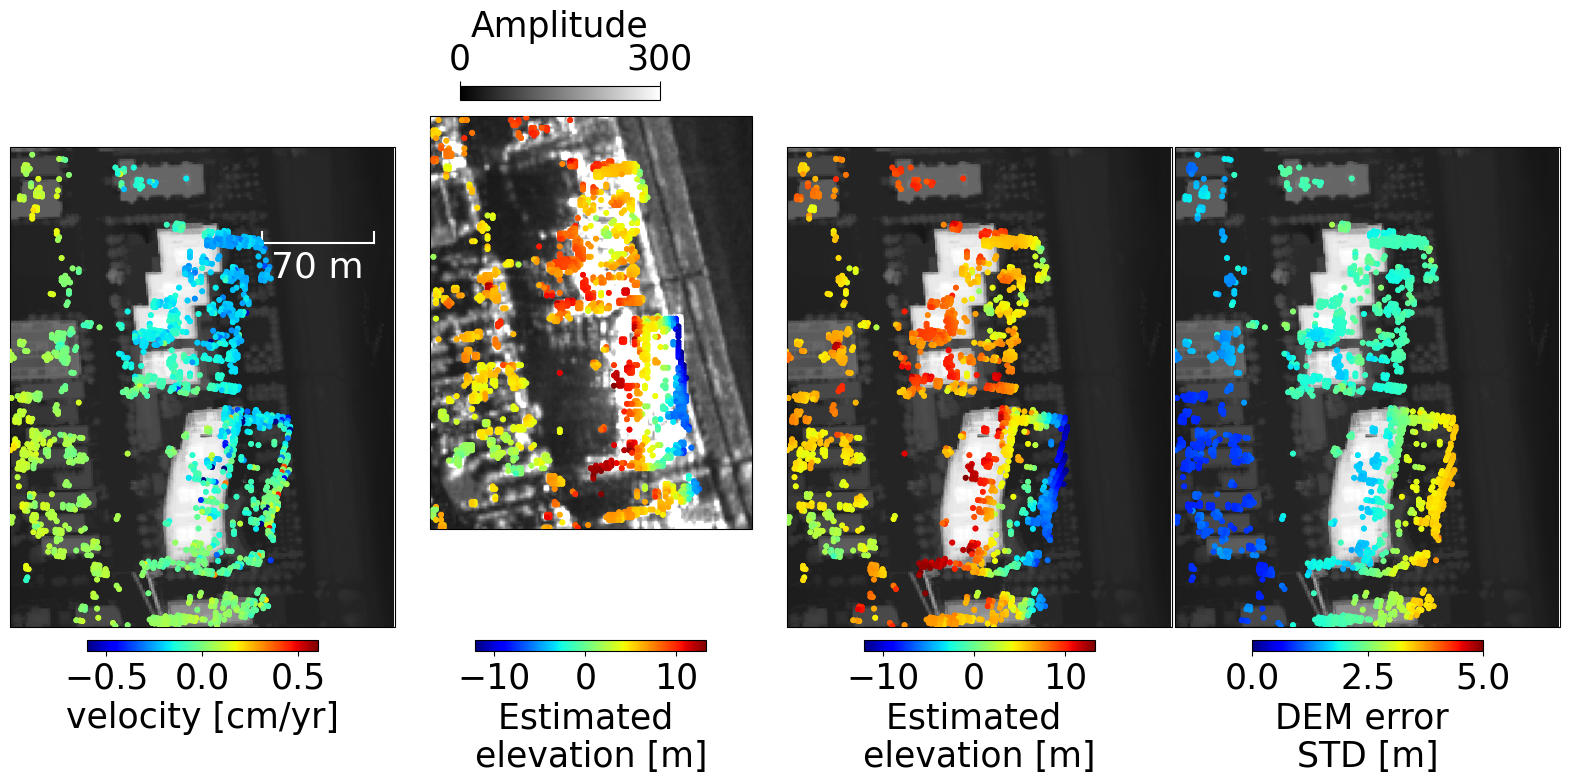

In [26]:
# PS velocity and DEM error after geolocation correction

refy = 319
refx = 1489
#box_rdr = [1490, 1527, 319, 344]
box_rdr = [525, 650, 1720, 1880]

box = ['25.876:25.879','-80.1224:-80.120']

plot_subset(box=box,box_rdr=box_rdr, ps=True, vel_range=0.6, amplitude_im=out_amplitude, 
            dem_offset=0, dem_name='dsm', out_name='supp_hotel_geolocation_tsx', 
            out_dir=out_dir, f1=-5, f2=50, corrected=False, pdd=0.18)


corrected
corrected
view.py ./../Sara/falk_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.876 25.879 --sub-lon -80.1224 -80.12 -v -5 50
view.py ./../Sara/falk_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.876 25.879 --sub-lon -80.1224 -80.12 -v -5 50
view.py ./../Sara/falk_data/dsm_reprojected_wgs84.tif --notitle --fontsize 12 --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noverbose --noreference --noscalebar --sub-lat 25.876 25.879 --sub-lon -80.1224 -80.12 -v -5 50


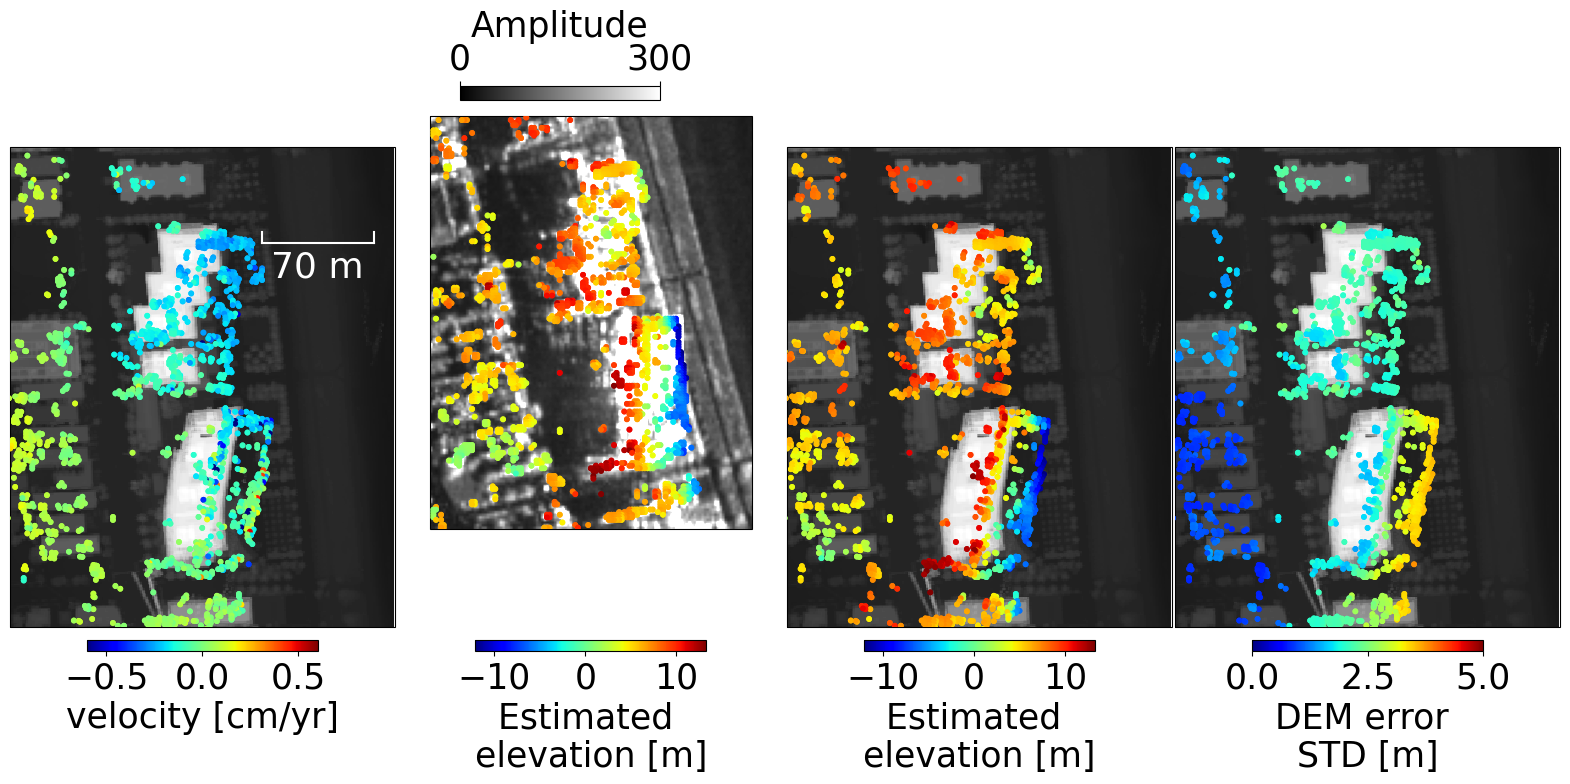

In [27]:
# PS velocity and DEM error after geolocation correction

refy = 319
refx = 1489
#box_rdr = [1490, 1527, 319, 344]
box_rdr = [525, 650, 1720, 1880]

box = ['25.876:25.879','-80.1224:-80.120']

plot_subset(box=box,box_rdr=box_rdr, ps=True, vel_range=0.6, amplitude_im=out_amplitude, 
            dem_offset=0, dem_name='dsm', out_name='supp_hotel_geolocation_corrected_tsx', 
            out_dir=out_dir, f1=-5, f2=50, corrected=True, pdd=0.18)


corrected
corrected


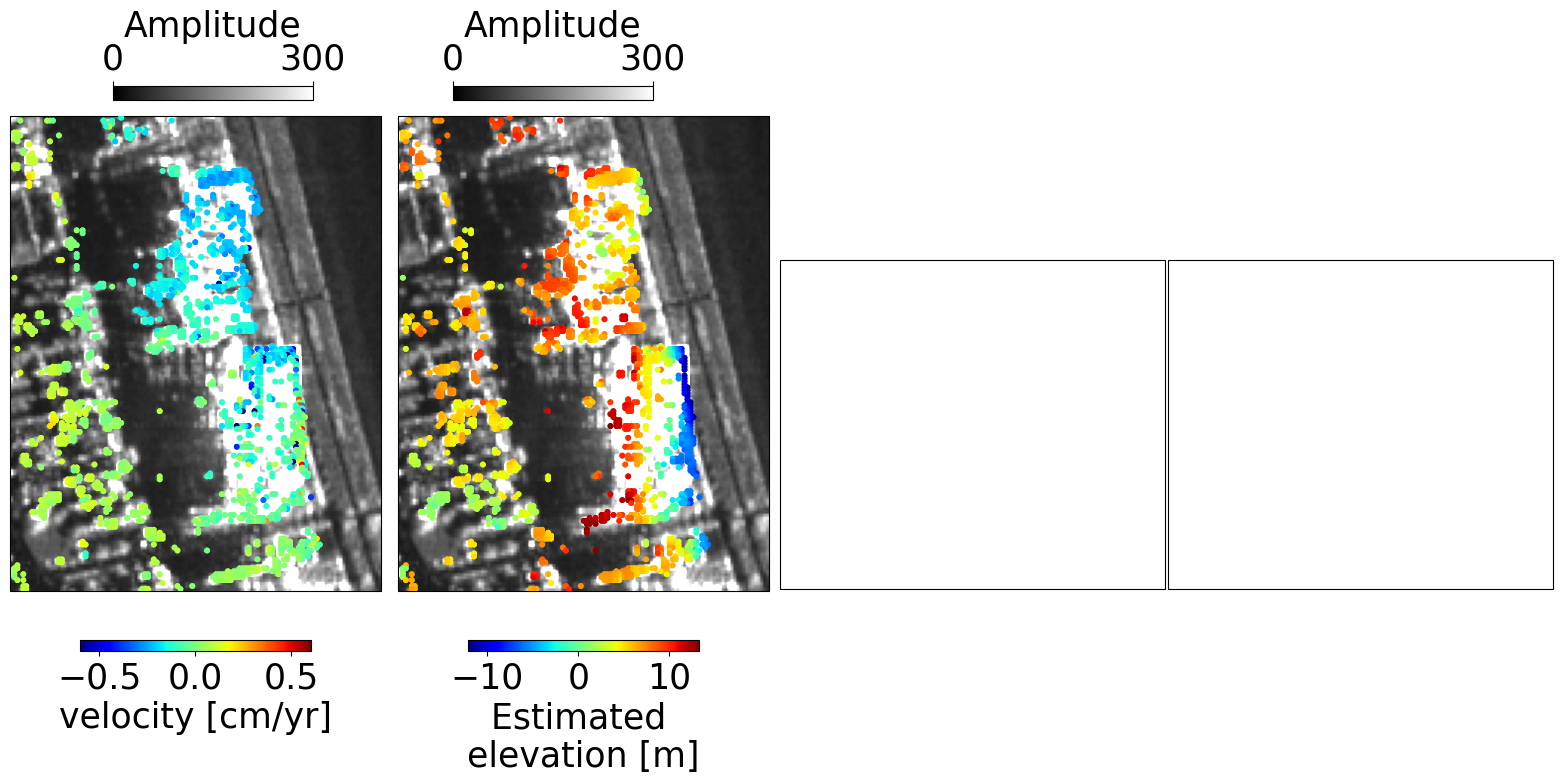

In [13]:
box_rdr = [525, 650, 1720, 1880]
box = ['25.87570:25.8789','-80.1229:-80.1202']
lats = [float(i) for i in box[0].split(':')]
lons = [float(i) for i in box[1].split(':')]
scale=10
padding=0.02

amplitudep,  xvp, yvp, lonp, latp, velp, demerrp, demerror_stdp, demp , ddemerrp, ddemp = get_data(lats, lons,box_rdr, True, out_amplitude, 26, True)
amplitude,  xv, yv, lon, lat, vel, demerr, demerror_std, dem , ddemerr, ddem = get_data(lats, lons,box_rdr, True, out_amplitude, 26, True)

fig, _axs = plt.subplots(nrows=1, ncols=4, 
                        figsize=(20,8), subplot_kw=dict(projection=ccrs.Mercator()))

axs = _axs.flatten()  
ax2 = axs[1]
pdd=0.08

imm=ax2.imshow(amplitudep, cmap='gray', vmin=0, vmax=300, origin='upper')
    
im = ax2.scatter(xv, yv, c=-ddemerr+ddem, s=scale, cmap='jet'); 
im.set_zorder(20)
im1 = ax2.scatter(xvp, yvp, c=-ddemerrp+ddemp, s=scale, cmap='jet'); 
im1.set_zorder(20)
cbar = plt.colorbar(im1, ax=ax2, shrink=0.6, orientation='horizontal', pad=pdd)
cbar.set_label('Estimated \nelevation [m]')
           
cbar_ax = fig.add_axes([0.35, 0.9, 0.1, 0.018])
fig.colorbar(imm, cax=cbar_ax, ticks=[0, 300], label='Amplitude', 
                orientation='horizontal', pad=padding)
cbar_ax.xaxis.set_ticks_position('top')
cbar_ax.xaxis.set_label_position('top')
 
ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)
fig.subplots_adjust(hspace=0.01, wspace=0.01)


ax1 = axs[0]
vel_range = 0.6
imm=ax1.imshow(amplitudep, cmap='gray', vmin=0, vmax=300, origin='upper')

im2 = ax1.scatter(xvp, yvp, c=velp/10, s=scale, cmap='jet', vmin=-vel_range, vmax=vel_range);
im = ax1.scatter(xv, yv, c=vel/10, s=scale, cmap='jet', vmin=-vel_range, vmax=vel_range); 
im.set_zorder(20)
im2.set_zorder(25)

cbar = plt.colorbar(im2, ax=ax1, shrink=0.6, orientation='horizontal', pad=pdd)
cbar.set_label('velocity [cm/yr]')



cbar_ax = fig.add_axes([0.18, 0.9, 0.1, 0.018])
fig.colorbar(imm, cax=cbar_ax, ticks=[0, 300], label='Amplitude', 
                orientation='horizontal', pad=padding)
cbar_ax.xaxis.set_ticks_position('top')
cbar_ax.xaxis.set_label_position('top')
 
ax1.axes.get_xaxis().set_visible(False)
ax1.axes.get_yaxis().set_visible(False)
fig.subplots_adjust(hspace=0.01, wspace=0.01)

plt.savefig(out_dir + '/tsx_velocity_elevation.png',bbox_inches='tight', dpi=300)


In [14]:
def get_data_ts(proj_dir, point, box, ps, refy, refx, yx=False):
    lats = [float(i) for i in box[0].split(':')]
    lons = [float(i) for i in box[1].split(':')]
    
    #ts_file = proj_dir + '/timeseries_SET_ERA5_demErr.h5'
    ts_file = proj_dir + '/timeseries_demErr.h5'
    geo_file = proj_dir + '/geo_corr/geometryRadar.h5'
    mask_file_t = proj_dir + '/maskTempCoh.h5'
    mask_file_ps = proj_dir + '/maskPS.h5'
    mask_file_w = proj_dir + '/waterMask.h5'
    vel_file = proj_dir + '/velocity.h5'
    
    velocity = readfile.read(vel_file, datasetName='velocity')[0]*1000
    
    stack_obj = timeseries(ts_file)
    stack_obj.open(print_msg=False)
    date_list = stack_obj.get_date_list()
    num_dates = len(date_list)
    
    mask_v = np.ones(velocity.shape)
    mask_v[np.abs(velocity) < 3] = 0
    


    
    mask_w = readfile.read(mask_file_w, datasetName='mask')[0]*mask_v
    mask_t = readfile.read(mask_file_t, datasetName='mask')[0]*mask_w
    mask_p = readfile.read(mask_file_ps, datasetName='mask')[0]*mask_w
    #
    
    if ps:
        mask = mask_p
    else:
        mask=mask_t

    latitude = readfile.read(geo_file, datasetName='latitude')[0]
    longitude = readfile.read(geo_file, datasetName='longitude')[0]
    
    mask[latitude<lats[0]] = 0
    mask[latitude>lats[1]] = 0
    mask[longitude<lons[0]] = 0
    mask[longitude>lons[1]] = 0

    
    lat = np.array(latitude[mask==1])
    lon = np.array(longitude[mask==1])
    
    ts = np.zeros([len(lat), num_dates])
    
    ts_p = np.zeros([point.shape[0], num_dates])
    ts_std = np.zeros([point.shape[0], num_dates])
    
    for i in range(point.shape[0]):
        if yx:
            dates_ts, ts_p[i,:], ts_std[i,:] = ut.read_timeseries_yx(point[i, 0], point[i, 1], ts_file, 
                                                      ref_y=refy, ref_x=refx,
                                                      win_size=2, unit='cm', print_msg=True)
        else:
            
            dates_ts, ts_p[i,:], ts_std[i,:] = ut.read_timeseries_lalo(point[i, 0], point[i, 1], ts_file, 
                                                      lookup_file=geo_file, ref_lat=refy, ref_lon=refx,
                                                      win_size=2, unit='cm', print_msg=True)
            
    
    #for i in range(len(lat)):
    #    dates_ts, ts[i, :] = ut.read_timeseries_lalo(lat[i], lon[i], ts_file, 
    #                                              lookup_file=geo_file, ref_lat=reflat, ref_lon=reflon,
    #                                              win_size=2, unit='mm', print_msg=True)[0:2]
    
    
    return lon, lat, dates_ts, ts, ts_p, ts_std

input lat / lon: 25.8782 / -80.1218
corresponding y / x: 1757 / 615
input lat / lon: 25.8778 / -80.1212
corresponding y / x: 1774 / 581
input lat / lon: 25.8782 / -80.1218
corresponding y / x: 337 / 1505
input lat / lon: 25.8778 / -80.1212
corresponding y / x: 333 / 1519


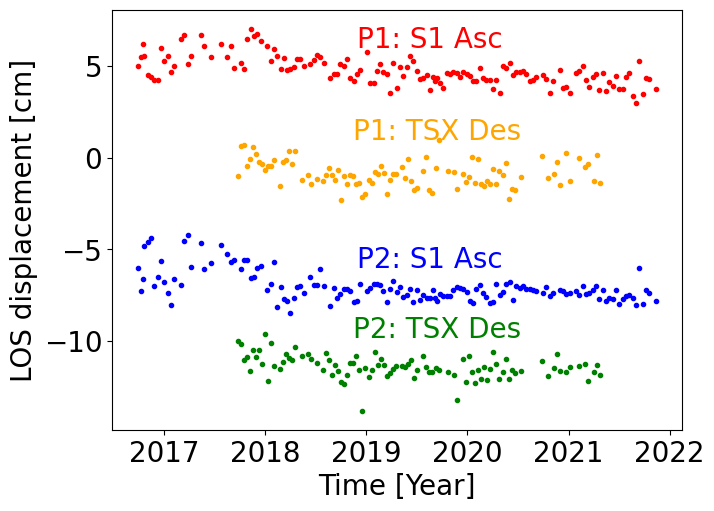

In [18]:
refy = 319
refx = 1489


refytsx = 601
refxtsx = 1887

reflat = 25.8759
reflon = -80.1219

box = ['25.876:25.879','-80.1224:-80.120'] 
point = np.array([[25.8783, -80.1213],
                  [25.8779, -80.1212]])

point = np.array([[25.8782, -80.1218],
                  [25.8778, -80.1212]])

#point = np.array([[337, 1504],
#                  [334, 1519]])

#25.8782, -80.1218
#25.8779, -80.1212
#25.8783, -80.1213 

#point = np.array([[336, 1520],
#                  [334, 1519]])

#point_tsx = np.array([[591, 1746],
#                      [588, 1770]])

#tsx: 591, 1746
# 588, 1770

#lon, lat, dates_ts, ts, ts_p, ts_std = get_data_ts(proj_dir=project_dir, point=point_tsx, 
#                                                   box=box, ps=True, refy=refytsx, refx=refxtsx, yx=True)

lon, lat, dates_ts, ts, ts_p, ts_std = get_data_ts(proj_dir=project_dir, point=point, 
                                                   box=box, ps=True, refy=reflat, refx=reflon, yx=False)

project_dir_sentinel = '/Users/saramirzaee/Documents/Sara/falk_data'


lons, lats, dates_tss, tss, ts_ps, ts_stds = get_data_ts(proj_dir=project_dir_sentinel, point=point, 
                                                   box=box, ps=True, refy=reflat, refx=reflon, yx=False)


plt.rcParams["font.size"] = "20"

fig = plt.figure(figsize=(15, 15), constrained_layout=False)
gs1 = fig.add_gridspec(nrows=1, ncols=1, left=0.02, right=0.4, top=0.98, bottom=0.7,
                        hspace=0.2, wspace=0.2)
ax1 = fig.add_subplot(gs1[0,0])
#ax2 = ax1.twinx()
#for i in range(ts.shape[0]):
#    ax1.plot(dates_ts[4::], ts[i,4::]-ts[i,4], '--', color='gray')
    
#ax1.errorbar(dates_ts[4::], ts_p[0, 4::]-ts_p[0, 4], yerr=ts_std[0,4::], color='red', fmt='-',capsize=4, linewidth=2)
#ax1.errorbar(dates_ts[4::], ts_p[1, 4::]-ts_p[1, 4] + 5, yerr=ts_std[1,4::], color='blue', fmt='-',capsize=4, linewidth=2)

ax1.plot(dates_tss[4::], ts_ps[0, 4::]-ts_ps[0, 4] + 5, '.', color='red',  linewidth=2)
ax1.plot(dates_ts[:], ts_p[0, :]-ts_p[0, 0]-1 , '.', color='orange',  linewidth=2)

ax1.plot(dates_tss[4::], ts_ps[1, 4::]-ts_ps[1, 4] - 6, '.', color='blue', linewidth=2)
ax1.plot(dates_ts[:], ts_p[1, :]-ts_p[1, 0] -10, '.', color='green', linewidth=2)



xxs = [(x-dates_tss[35]).days for x in dates_tss[35:-16]]
res1 = stats.linregress(xxs, ts_ps[0, 35:-16]-ts_ps[0, 4]+5)
#ax1.plot(dates_tss[35:-16], res1.intercept + res1.slope * np.array(xxs), 'k--', linewidth=2)
#ax1.text(dates_tss[40], 3.5, '{:.1f} +/- {:.1f} mm/yr (LOS) S1 Asc'.format(res1.slope*3652.5, res1.stderr*3652.5), color='red')
ax1.text(dates_tss[60], 6, 'P1: S1 Asc', color='red')

res1 = stats.linregress(xxs, ts_ps[1, 35:-16]-ts_ps[1, 4]-6)
#ax1.plot(dates_tss[35:-16], res1.intercept + res1.slope * np.array(xxs), 'k--', linewidth=2)
#ax1.text(dates_tss[40], -6, '{:.1f} +/- {:.1f} mm/yr (LOS) S1 Asc'.format(res1.slope*3652.5, res1.stderr*3652.), color='blue')
ax1.text(dates_tss[60], -6, 'P2: S1 Asc', color='blue')


xx = [(x-dates_ts[9]).days for x in dates_ts[9::]]
res1 = stats.linregress(xx, ts_p[0, 9::]-ts_p[0, 0]-1)
#ax1.plot(dates_ts[9::], res1.intercept + res1.slope * np.array(xx), 'k--', linewidth=2)
#ax1.text(dates_ts[13], -1, '{:.1f} +/- {:.1f} mm/yr (LOS) TSX Des'.format(res1.slope*3652.5, res1.stderr*3652.5), color='orange')
ax1.text(dates_ts[33], 1, 'P1: TSX Des', color='orange')

res1 = stats.linregress(xx, ts_p[1, 9::]-ts_p[1, 0]-10)
#ax1.plot(dates_ts[9::], res1.intercept + res1.slope * np.array(xx), 'k--', linewidth=2)
#ax1.text(dates_ts[13], -9.8, '{:.1f} +/- {:.1f} mm/yr (LOS) TSX Des'.format(res1.slope*3652.5, res1.stderr*3652.), color='green')
ax1.text(dates_ts[33], -9.8, 'P2: TSX Des', color='green')




years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('%Y')
ax1.xaxis.set_major_locator(years)
ax1.xaxis.set_major_formatter(years_fmt)
ax1.set_xlabel('Time [Year]')
ax1.set_ylabel('LOS displacement [cm]')
y1lim = np.array([-12, 5])
y2lim = y1lim / np.cos(np.deg2rad(44))

#ax1.set_ylim(y1lim)
#ax2.set_ylim(y2lim)
#ax2.set_yticks([-9, -6, -3, 0, 3])
#ax2.set_ylabel('Vertical displacement [cm]')

plt.savefig(out_dir + '/ref_miami_ts_hotel_s1_tsx.png', bbox_inches='tight', transparent=True, dpi=300)
plt.show()